In [4]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import statsmodels.api as sm  

df = pd.read_csv("QSurvey_Synthetic.csv", encoding='ISO-8859-1')


In [12]:
df.iloc[:, 4:].describe()

,DV1,DV2,DV1_Speaker,DV2_Gov,Treatment
count,402.000000,402.000000,402.000000,402.000000,402.000000
mean,3.703980,2.659204,0.898010,0.527363,0.500000
std,0.962869,1.066739,0.303012,0.499873,0.500623
min,1.000000,1.000000,0.000000,0.000000,0.000000
25%,3.000000,2.000000,1.000000,0.000000,0.000000
50%,4.000000,3.000000,1.000000,1.000000,0.500000
75%,4.000000,4.000000,1.000000,1.000000,1.000000
max,5.000000,5.000000,1.000000,1.000000,1.000000


In [6]:
#define treatment
df['Treatment'] = (df['FL_22_DO'] == 'FL_24').astype(int)

# Assuming df is your cleaned DataFrame with 'Treatment', 'DV1_High' and 'DV2_High'
df['DV1_Speaker'] = df['DV1'].apply(lambda x: 1 if x >= 3 else 0)
df['DV2_Gov'] = df['DV2'].apply(lambda x: 1 if x >= 3 else 0)

# DV1
X1 = sm.add_constant(df['Treatment'])  # 1 = rhetorical bypassing (FL_24)
y1 = df['DV1_Speaker']
model1 = sm.Logit(y1, X1).fit()
print(model1.summary())

# DV2
X2 = sm.add_constant(df['Treatment'])
y2 = df['DV2_Gov']
model2 = sm.Logit(y2, X2).fit()
print(model2.summary())

Optimization terminated successfully.
         Current function value: 0.329400
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            DV1_Speaker   No. Observations:                  402
Model:                          Logit   Df Residuals:                      400
Method:                           MLE   Df Model:                            1
Date:                Mon, 14 Jul 2025   Pseudo R-squ.:               0.0001026
Time:                        07:43:27   Log-Likelihood:                -132.42
converged:                       True   LL-Null:                       -132.43
Covariance Type:            nonrobust   LLR p-value:                    0.8691
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1484      0.231      9.317      0.000       1.696       2.600
Treatment      0.0543      0.

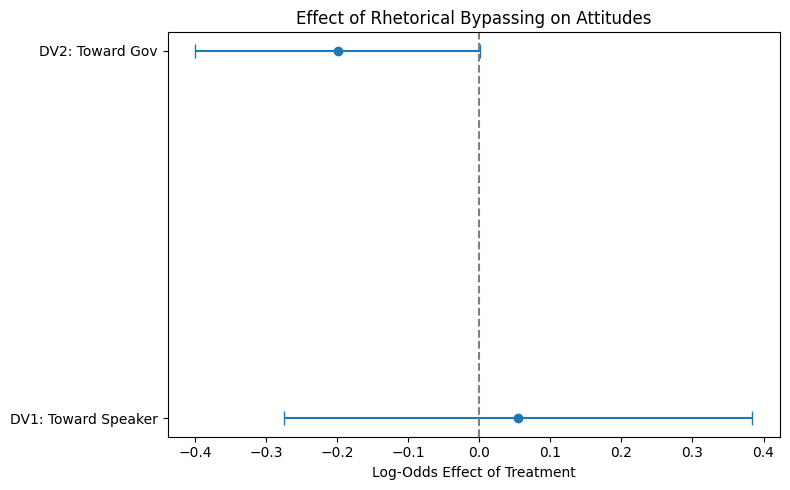

In [14]:
coefs = [model1.params['Treatment'], model2.params['Treatment']]
errors = [model1.bse['Treatment'], model2.bse['Treatment']]

labels = ['DV1: Toward Speaker', 'DV2: Toward Gov']

plt.figure(figsize=(8, 5))
plt.errorbar(coefs, labels, xerr=errors, fmt='o', capsize=5)
plt.axvline(x=0, linestyle='--', color='gray')
plt.xlabel('Log-Odds Effect of Treatment')
plt.title('Effect of Rhetorical Bypassing on Attitudes')
plt.tight_layout()
plt.show()

In [16]:
# Add constant to predictors
X = sm.add_constant(df['Treatment'])

# Regression for DV1
model_dv1 = sm.OLS(df['DV1_avg'], X).fit()

# Regression for DV2
model_dv2 = sm.OLS(df['DV2_avg'], X).fit()

KeyError: 'DV1_avg'

In [15]:
# Collect coefficients and confidence intervals
coefs = pd.DataFrame({
    'DV1_avg': model_dv1.params,
    'DV1_ci_lower': model_dv1.conf_int()[0],
    'DV1_ci_upper': model_dv1.conf_int()[1],
    'DV2_avg': model_dv2.params,
    'DV2_ci_lower': model_dv2.conf_int()[0],
    'DV2_ci_upper': model_dv2.conf_int()[1],
}).loc['Treatment']  # only the Treatment row

# Create the plot
fig, ax = plt.subplots(figsize=(7, 5))
ax.errorbar(x=coefs[['DV1_avg', 'DV2_avg']],
            y=[1, 0],
            xerr=[[
                coefs['DV1_avg'] - coefs['DV1_ci_lower'],
                coefs['DV2_avg'] - coefs['DV2_ci_lower']
            ], [
                coefs['DV1_ci_upper'] - coefs['DV1_avg'],
                coefs['DV2_ci_upper'] - coefs['DV2_avg']
            ]],
            fmt='o', capsize=5)

ax.set_yticks([0, 1])
ax.set_yticklabels(['DV2: Attitude Toward Gov', 'DV1: Attitude Toward Speaker'])
ax.axvline(0, color='grey', linestyle='--')
ax.set_xlabel('Coefficient')
ax.set_title('Effect of Rhetorical Bypassing (Treatment)')

plt.tight_layout()
plt.show()


NameError: name 'model_dv1' is not defined

In [ ]:
#NEW SECTION: SYNTHETIC DVs
#The themes I outlined in my theory are:
# (1) Backlash and Defensive nationalism (2) Normative shifts (3) Trust (4) Distinguishing ppl from gov

#DV1 Attitudes toward the speaker: trust, distinction, norms
## Q10: Do you believe the Canadian Prime Minister's criticism was sincere?
## Q11 Did the message make you feel more favorable toward the Canadian gov?
## Q14 How would you rate yout feelings toward the Canadian prime minister?

#DV2 Attitudes toward their gov: backlash/defensive nationalism, norm, viable audiences
##Q9 I support the US gov
##Q12 I feel more critical of the US gov after reading the article
##Q13 I believe the US should reconsider its current approach.

''' 
Pre Questions:
Q4 My political preferences lean...
o	Very liberal  (1) 
o	Liberal  (2) 
o	Moderate  (3) 
o	Conservative  (4) 
o	Very conservative  (5) 
o	Prefer not to say  (6) 

Q5 I take pride in the U.S. Constitution and feel that its core values align with my personal beliefs.
o	Strongly disagree  (1) 
o	Somewhat disagree  (2) 
o	Neither agree nor disagree  (3) 
o	Somewhat agree  (4) 
o	Strongly agree  (5) 

Q6 I would rather be a citizen of America than any other country.
o	Strongly disagree  (1) 
o	Somewhat disagree  (2) 
o	Neither agree nor disagree  (3) 
o	Somewhat agree  (4) 
o	Strongly agree  (5) 

Q7 It would be disrespectful for myself or another American to criticize U.S. policies.
o	Strongly disagree  (1) 
o	Somewhat disagree  (2) 
o	Neither agree nor disagree  (3) 
o	Somewhat agree  (4) 
o	Strongly agree  (5) 

'''

'''
Q8 At this moment, which government do you feel most morally aligned with?
o	The United States  
o	Canada  
o	Neither  
o	Other (please specify)  

Q9 Indicate your level of agreement:   I felt the need to defend and support the U.S. after reading the Prime Minister's remarks.
o	Strongly disagree  
o	Somewhat disagree  
o	Neither agree nor disagree  
o	Somewhat agree  
o	Strongly agree  

Q10 The Prime Minister's remarks reflect my own concerns and I felt understood, even if I felt the need to defend the U.S.
o	Strongly disagree  
o	Somewhat disagree  
o	Neither agree nor disagree  
o	Somewhat agree  
o	Strongly agree  

Q11 I believe the Prime Minister’s message was sincere.
o	Strongly disagree   
o	Somewhat disagree  
o	Neither agree nor disagree  
o	Somewhat agree  
o	Strongly agree 

Q12 I support the Prime Minister's right to comment on this issue.
o	Strongly disagree  
o	Somewhat disagree  
o	Neither agree nor disagree  
o	Somewhat agree  
o	Strongly agree  

Q13 After reading this article, my view on the Canadian Prime Minister is...
o	Extremely negative  
o	Somewhat negative  
o	Neither positive nor negative  
o	Somewhat positive  
o	Extremely positive  

Q14 After reading this article, my view of the U.S. government is... 
o	Extremely negative  
o	Somewhat negative  
o	Neither positive nor negative  
o	Somewhat negative  
o	Somewhat positive  

Q15 Based on the article you read, how much do you support the U.S. government's data policy?
o	Not at all  
o	Slightly  
o	Somewhat  
o	Mostly  
o	Extremely  
o	Not sure  

'''

